In [3]:
#bulk RNA-seq & Nanopore
#基于转录组测序技术分析冠状病毒基因组
%matplotlib inline
%load_ext autoreload
%autoreload 2
#%matplotlib inline可以在Notebook中直接显示图形输出，%load_ext autoreload和%autoreload 2用于自动重新加载模块

In [4]:
import os
os.getcwd()

'C:\\Users\\dgwei\\PycharmProjects\\pythonProject2'

In [5]:
#bulk RNA-seq
import os
os.chdir("D:/360MoveData/Users/dgwei/Desktop/BASIC/bulk_RNAseq/")
from plotly.offline import plot
from IPython.display import IFrame
import pandas as pd
import numpy as np
import shutil#os模块的补充，提供了复制、移动、删除、压缩、解压等操作
from tabulate import tabulate#打印漂亮的表格数据
import matplotlib.pyplot as plt

In [6]:
orfcolors = pd.read_csv('PEDV-colorcode-rainbow.txt', sep=' ', names=['orf', 'color'], index_col=0)['color'].to_dict()
orfcolors

{'ORF1a': '#c5d9ea',
 'ORF1b': '#e8d2c4',
 'S': '#82c91e',
 'ORF3a': '#3bc9db',
 'E': '#228be6',
 'M': '#9fb1fc',
 'N': '#ffd43b'}

In [7]:
anno = pd.read_csv('reference/PEDV-annotations.gff', sep='\t', names=['chrom', 'type', 'name', 'start', 'end', 'x', 'y', 'z'])
anno

,chrom,type,name,start,end,x,y,z
0,MK584552.1,CDS,E,25446,25676,0.0,.,.
1,MK584552.1,CDS,M,25684,26364,0.0,.,.
2,MK584552.1,CDS,N,26376,27701,0.0,.,.
3,MK584552.1,CDS,ORF3a,24791,25465,0.0,.,.
4,MK584552.1,CDS,S,20634,24791,0.0,.,.


In [8]:
cdsanno = anno[anno['type'] == 'CDS']
#cdsanno = cdsanno.iloc[:10].sort_values(by='start').iloc[:9]
cdsanno = cdsanno.iloc[:10].sort_values(by='start')
#loc：通过行、列的名称或标签来索引
#iloc：通过行、列的索引位置来寻找数据
cdsanno = pd.concat([
    cdsanno,
    pd.DataFrame([
        pd.Series(['MK584552.1', 'CDS', 'ORF1a', 293, 12601, '.', '.', '.'], index=cdsanno.columns),
        pd.Series(['MK584552.1', 'CDS', 'ORF1b', 12601,20637, '.', '.', '.'], index=cdsanno.columns),
    ])])
cdsanno = cdsanno.sort_values(by='start').iloc[:, 2:5].reset_index(drop=True)
cdsanno['color'] = cdsanno['name'].apply(orfcolors.__getitem__)
cdsanno.to_pickle('./tmp/cdsannotation.pickle')
cdsanno

,name,start,end,color
0,ORF1a,293,12601,#c5d9ea
1,ORF1b,12601,20637,#e8d2c4
2,S,20634,24791,#82c91e
3,ORF3a,24791,25465,#3bc9db
4,E,25446,25676,#228be6
5,M,25684,26364,#9fb1fc
6,N,26376,27701,#ffd43b


In [9]:
#导入病毒比对数据
#viralcoverage = pd.read_csv('result/PEDV-luo-invirion/PEDV.virus.coverage.txt', sep='\t', names=['chrom', 'pos', 'count'])
viralcoverage = pd.read_csv('result/PEDV-luo-incell/PEDV.virus.coverage.txt', sep='\t', names=['chrom', 'pos', 'count'])
#viralcoverage = pd.read_csv('result/SARS2.virus.nodup.coverage.txt', sep='\t', names=['chrom', 'pos', 'count'])

In [10]:
# STRIDESIZE = 30
STRIDESIZE = 30
plt.rcParams['ytick.labelright'] = True
plt.rcParams['ytick.labelleft'] = False
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.left'] = False

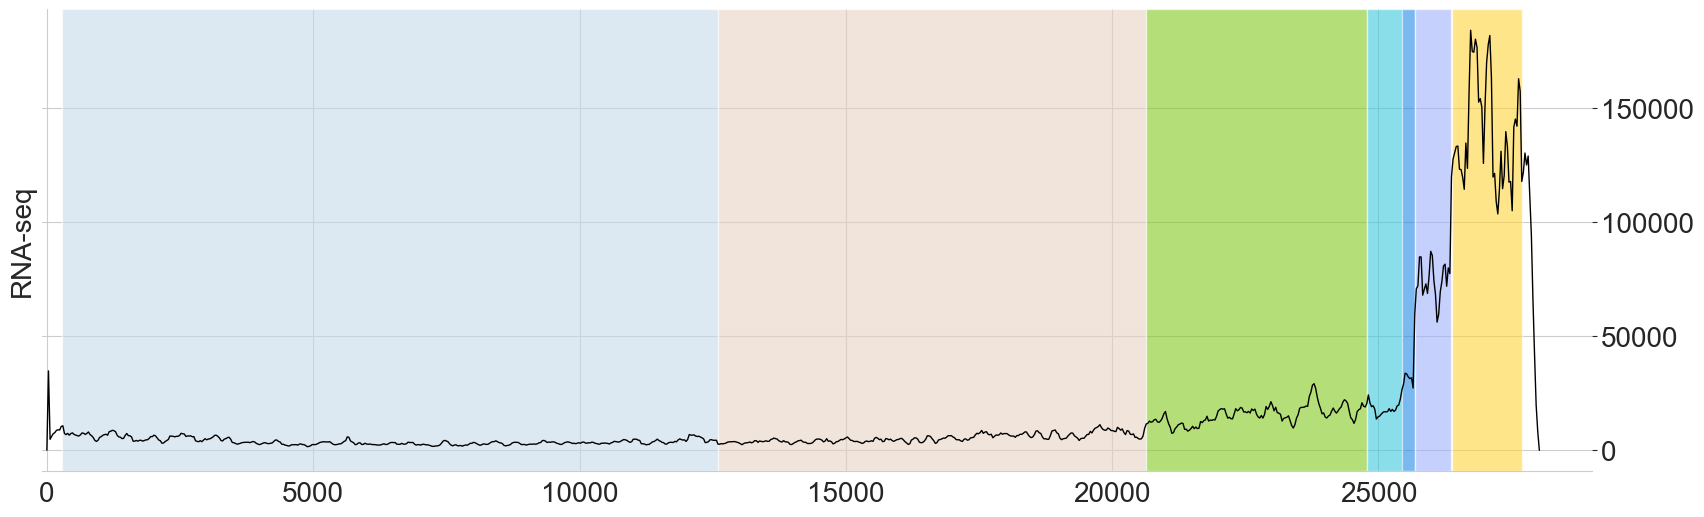

In [11]:
#覆盖度
def plot_hist(ax, data, title):
    data = data.copy()
    data['binpos'] = np.floor(data['pos'] / STRIDESIZE).astype(int) * STRIDESIZE
    medcov = data.groupby('binpos').agg({'count': 'median'})

    #ax.fill_between(medcov.index, 0, medcov['count'].tolist())
    ax.plot(medcov.index, medcov['count'].tolist(), c='black', lw=1)
    ax.set_xlim(-100, 29000)
    ax.set_ylabel(title,fontsize=20)

    for _, row in cdsanno.iterrows():
        ax.axvspan(row['start'], row['end'], fc=row['color'], alpha=.6, zorder=1)
        # if ax is axes:
        #     ax.annotate(row['name'].replace('ORF', ''),
        #                 ((row['start'] + row['end'])/2, medcov['count'].max()),fontsize=8)

    for spside in 'top left right'.split():#图的上、左、右边框设置为不可见
        plt.setp(ax.spines[spside], visible=False)

    ax.grid(True)#行网格线
    plt.setp(ax.get_xgridlines(), visible=True)#列网格线
    # # 修改 x 轴和 y 轴的标签大小
    # ax.set_xlabel('X 轴标签', fontsize=12)
    # ax.set_ylabel('Y 轴标签', fontsize=12)
    # 修改 x 轴和 y 轴的刻度标签大小
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    #
    # 修改 x 轴和 y 轴的刻度线大小
    # ax.tick_params(axis='x', which='major', length=7)
    # ax.tick_params(axis='y', which='major', length=7)

    # 修改 x 轴和 y 轴的刻度线标签朝向
    # ax.tick_params(axis='x', labelrotation=45)  # 旋转 x 轴刻度标签
    # ax.tick_params(axis='y', labelrotation=90)  # 旋转 y 轴刻度标签


#fig, axes = plt.subplots(2, 1, figsize=(5.74, 4))
fig, axes = plt.subplots(1, 1, figsize=(20, 6))
plot_hist(axes, viralcoverage, 'RNA-seq')
# plt.savefig('D:/360MoveData/Users/dgwei/Desktop/BASIC/two-dimensional data analysis/PEDV-incell-.')
#plot_hist(axes[0], covViral, 'Nanopore')
# plt.savefig('result/readdepth.RNAseq.pdf')
# plt.savefig('result/readdepth.RNAseq.png')

In [12]:
#part of coverage
STRIDESIZE = 15

plt.rcParams['ytick.labelright'] = False
plt.rcParams['ytick.labelleft'] = True
plt.rcParams['ytick.right'] = False
plt.rcParams['ytick.left'] = True

RIGHTEND = 20000
IGNOREFIRST_FORYMAX = 100

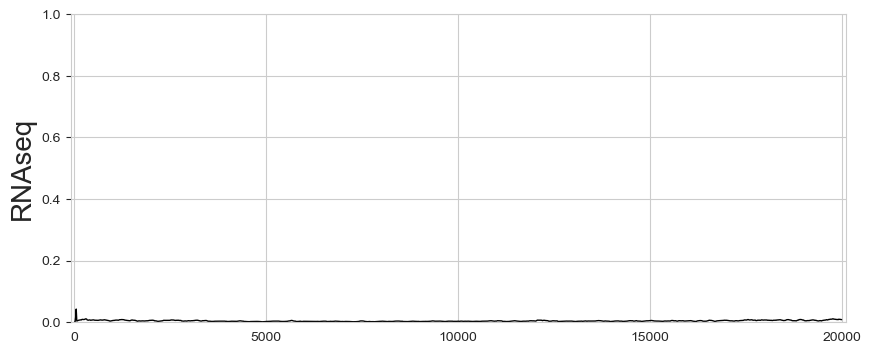

In [13]:
def plot_hist(ax, data, title, xticks, yticks):
    data = data.copy()
    data['binpos'] = np.floor(data['pos'] / STRIDESIZE).astype(int) * STRIDESIZE
    medcov = data.groupby('binpos').agg({'count': 'median'})
    medcov = medcov[medcov.index.to_series().between(0, RIGHTEND)]

    medcov_noleader = medcov[medcov.index.to_series() >= IGNOREFIRST_FORYMAX]

    #ax.fill_between(medcov.index, 0, medcov['count'].tolist())
    ax.plot(medcov.index, medcov['count'].tolist(), c='black', lw=1)
    ax.set_xlim(-100, RIGHTEND+100)
    ax.set_ylim(0, medcov_noleader['count'].max())
    ax.set_ylabel(title,fontsize=20)
    ax.set_xticks(xticks,fontsize=15)
    ax.set_yticks(yticks,fontsize=15)
    if np.max(yticks) >= 1000000:
        ax.set_yticklabels(yticks / 1000000)
    elif np.max(yticks) >= 1000:
        ax.set_yticklabels(yticks / 1000)

    ax.grid(True)
    plt.setp(ax.get_xgridlines(), visible=True)

fig, axes = plt.subplots(1, 1, figsize=(10,4))
# plot_hist(axes[0], covViral, 'Nanopore', np.arange(0, 20001, 5000), np.arange(0, 12001, 2000))
plot_hist(axes, viralcoverage, 'RNAseq', np.arange(0, 20001, 5000), np.arange(0, 1000001, 200000))
# plt.savefig('result/readdepth-detailed.pdf')
# plt.savefig('result/readdepth-detailed.png')

In [14]:
import matplotlib.pyplot as plt
# 获取所有可用的色彩映射
all_colormaps = plt.colormaps()
all_colormaps
# 打印所有色彩映射


['magma',
 'inferno',
 'plasma',
 'viridis',
 'cividis',
 'twilight',
 'twilight_shifted',
 'turbo',
 'Blues',
 'BrBG',
 'BuGn',
 'BuPu',
 'CMRmap',
 'GnBu',
 'Greens',
 'Greys',
 'OrRd',
 'Oranges',
 'PRGn',
 'PiYG',
 'PuBu',
 'PuBuGn',
 'PuOr',
 'PuRd',
 'Purples',
 'RdBu',
 'RdGy',
 'RdPu',
 'RdYlBu',
 'RdYlGn',
 'Reds',
 'Spectral',
 'Wistia',
 'YlGn',
 'YlGnBu',
 'YlOrBr',
 'YlOrRd',
 'afmhot',
 'autumn',
 'binary',
 'bone',
 'brg',
 'bwr',
 'cool',
 'coolwarm',
 'copper',
 'cubehelix',
 'flag',
 'gist_earth',
 'gist_gray',
 'gist_heat',
 'gist_ncar',
 'gist_rainbow',
 'gist_stern',
 'gist_yarg',
 'gnuplot',
 'gnuplot2',
 'gray',
 'hot',
 'hsv',
 'jet',
 'nipy_spectral',
 'ocean',
 'pink',
 'prism',
 'rainbow',
 'seismic',
 'spring',
 'summer',
 'terrain',
 'winter',
 'Accent',
 'Dark2',
 'Paired',
 'Pastel1',
 'Pastel2',
 'Set1',
 'Set2',
 'Set3',
 'tab10',
 'tab20',
 'tab20b',
 'tab20c',
 'magma_r',
 'inferno_r',
 'plasma_r',
 'viridis_r',
 'cividis_r',
 'twilight_r',
 'twilight

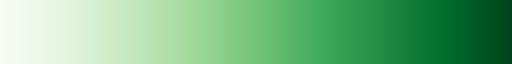

In [15]:
from copy import copy

# palette = copy(plt.cm.viridis)
palette = copy(plt.cm.Greens)
palette.set_over('magenta', 1.0)
palette.set_under('black', 1.0)
palette.set_bad('magenta', 1.0)
palette

In [16]:
from matplotlib import colors
from scipy.signal import find_peaks

In [17]:
orfcolors = pd.read_csv('PEDV-colorcode-rainbow.txt', sep=' ', names=['orf', 'color'], index_col=0)['color'].to_dict()

In [18]:
annotations = pd.read_csv('reference/PEDV-annotations.gff', sep='\t',
                         names=['chrom', 'type', 'name', 'start', 'end', '_x', '_y', '_z'])
annotations['start'] -= 1
cdsanno = annotations[(annotations['type'] == 'CDS') &
                      (~annotations['name'].isin(['ORF10', 'nsp1', 'frameshift'])) &
                      (~annotations['name'].apply(lambda x: x.startswith('nsp')))]
cdsanno = pd.concat([
    cdsanno,
    pd.DataFrame([
        pd.Series(['MK584552.1', 'CDS', 'ORF1a', 293, 12601, '.', '.', '.'], index=cdsanno.columns),
        pd.Series(['MK584552.1', 'CDS', 'ORF1b', 12601,20637, '.', '.', '.'], index=cdsanno.columns),
    ])
]).sort_values(by='start').reset_index(drop=True).iloc[:, :5]

In [19]:
# largedels_mgi = pd.read_csv('result/PEDV-luo-incell/PEDV.jumps.txt', names=['j5', 'j3', 'count'], sep='\t')
largedels_mgi = pd.read_csv('result/PEDV-luo-invirion/PEDV.jumps.txt', names=['j5', 'j3', 'count'], sep='\t')
largedels_mgi

,j5,j3,count
0,52,17353,1
1,53,16012,1
2,53,17352,1
3,54,21766,1
4,55,13413,1
...,...,...,...
44312,27858,27934,1
44313,27868,27908,1
44314,27874,27904,1
44315,27901,27933,1


In [20]:
tilesize = 100
largedels_mgi['j5_tile'] = ((largedels_mgi['j5'] // tilesize) * tilesize + tilesize/2).astype(int)
largedels_mgi['j3_tile'] = ((largedels_mgi['j3'] // tilesize) * tilesize + tilesize/2).astype(int)

In [21]:
tiled_counts = largedels_mgi.groupby(['j5_tile', 'j3_tile']).agg({'count': 'sum'}).reset_index()
# tiled_counts

In [22]:
trv = tiled_counts.pivot(index='j5_tile', columns='j3_tile', values=['count']).fillna(0).astype(int)
#pivot将一个dataframe的记录数据整合成表格(类似Excel中的数据透视表功能)
# trv

In [23]:
juncdensity = np.log2(trv+1).T.values
juncdensity.shape

(279, 280)

In [125]:
# new_array = juncdensity[:, :185]
# juncdensity=new_array
# juncdensity.shape

(185, 185)

In [24]:
juncdensity[np.triu_indices(juncdensity.shape[0], k=1, m=None)] = np.nan
#这段代码使用了 NumPy 中的 np.triu_indices 函数来将矩阵 juncdensity 的上三角部分（不包括对角线）的元素设置为 NaN。

In [25]:
PADSIZE = 4
jdpadded = np.hstack([juncdensity[:, :1]] * PADSIZE + [juncdensity])
jdpadded.shape

(279, 284)

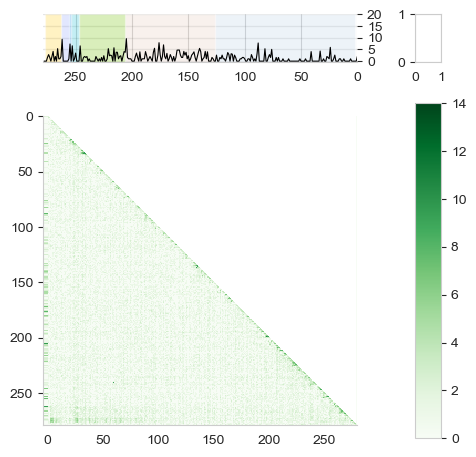

In [27]:
COLORMAX = 14
NUMBINS = jdpadded.shape[0]

fig, axes = plt.subplots(2, 2, figsize=(4.8, 4.8),
                         gridspec_kw={'width_ratios': [12, 1], 'height_ratios': [1, 7]})

ax = axes[0, 0]
trsl_density = np.log2(trv['count'].iloc[0]+1).values
ax.plot(np.arange(len(trsl_density)), trsl_density, c='black', lw=.8, zorder=2)
for sp in 'top left right'.split():
    ax.spines[sp].set_visible(False)
peakpos = find_peaks(trsl_density, prominence=8, height=13)[0]
ax.scatter(peakpos, [trsl_density[p] for p in peakpos],
           c='red', s=11, edgecolor='none', zorder=3)
for _, cds in cdsanno.iterrows():
    color = orfcolors[cds['name']]
    ax.axvspan(cds['start'] // tilesize, cds['end'] // tilesize, fc=color,alpha=.3)
ax.set_xticks(np.arange(0, NUMBINS+1, 50))
ax.set_xlim(0, NUMBINS)
ax.yaxis.grid(True, lw=1, c='black', alpha=.1)
ax.set_yticks(np.arange(0, 21, 5))
ax.invert_xaxis()
ax.yaxis.tick_right()

ax = axes[1, 0]
cbo = ax.pcolor(jdpadded, cmap=palette,norm=colors.Normalize(vmin=0, vmax=COLORMAX),rasterized=True)
ax.set_xticks(np.arange(0, NUMBINS, 50) + PADSIZE)
ax.set_aspect(1)
ax.set_xlim(0, jdpadded.shape[1])
ax.set_xticklabels(np.arange(0, NUMBINS, 50))
ax.invert_yaxis()
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

plt.colorbar(cbo, shrink=.6, cax=axes[1, 1])
# plt.gca().invert_xaxis()
plt.tight_layout()
# plt.savefig('result/plot-junctions-mgiseq.pdf', dpi=1200)
# plt.savefig('result/plot-junctions-mgiseq.png', dpi=1200)

In [173]:
#距离衰减曲线
import numpy as np
import matplotlib.pyplot as plt
from ric_fun import get_oe, get_matrix_npz
from scipy.stats.mstats import zscore
matrix1 = pd.read_csv('../three-dimensional data analysis/SARS2_caocc.5nt.none.matrix', names=['S', 'E', 'value'], sep='\t')
matrix2 = pd.read_csv('../three-dimensional data analysis/PEDV_in_Virion.5nt.raw.matrix', names=['S', 'E', 'value'], sep='\t')
max(matrix1['E']-matrix1['S'])

29870

In [162]:
def extract_matrix(data, res):
    data['S'] = data['S'] / res
    data['E'] = data['E'] / res
    mat = get_matrix_npz(data, data)
    oe, dis = get_oe(mat)
    return mat, dis

In [163]:
def z_score(x):
    '''x∗=(x−μ)/σ'''
    x_mean=np.mean(x)
    s2=sum([(i-np.mean(x))*(i-np.mean(x)) for i in x])/len(x)
    return [(i-x_mean)/s2+1.5 for i in x]

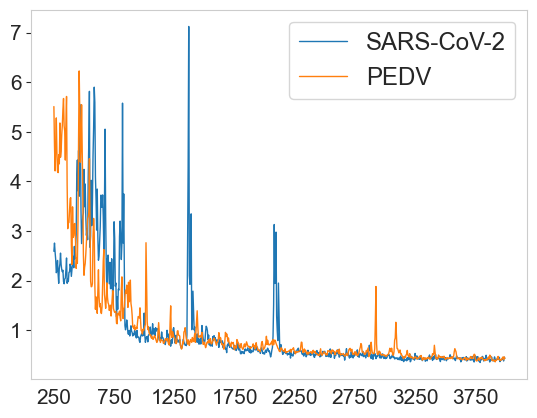

In [174]:
ma_SARS2_wdh_vero24h_rep1,dis_SARS2_wdh_vero24h_rep1 = extract_matrix(matrix1, 5)
ma_SARS2_wdh_vero24h_rep2,dis_SARS2_wdh_vero24h_rep2 = extract_matrix(matrix2, 5)
plt.figure()
plt.grid(False)
plt.plot(zscore(dis_SARS2_wdh_vero24h_rep1[50:800])+1, label = 'SARS-CoV-2',linewidth=1)
plt.plot(zscore(dis_SARS2_wdh_vero24h_rep2[50:800]*8)+1, label = 'PEDV',linewidth=1)
plt.xticks(np.arange(0,800,100), np.arange(50,800,100)*5,fontsize=15)
# plt.yticks(np.arange(0,10,2),fontsize=30)
plt.yticks(fontsize=15)
# plt.plot(zscore(dis_SARS2_wdh_vero24h_rep1)+1, label = 'SARSCoV2-incell',linewidth=1)
# plt.plot(zscore(dis_SARS2_wdh_vero24h_rep2)+1, label = 'PEDV-virion',linewidth=1)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.ylim(0, 10)
plt.legend(loc='upper right',fontsize="xx-large")
plt.savefig('../three-dimensional data analysis/distance.res5.y10.png', dpi=1200)
plt.show()

In [ ]:
# np.argmax(dis_SARS2_wdh_vero24h_rep2)*5

In [ ]:
#不同sgRNA比对数（super）
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv("D:/360MoveData/Users/dgwei/Desktop/BASIC/bulk_RNAseq/result/SARS2-wdh-vero24h.rep1/SARS2-wdh-1_bwa_rnaseq.out.tab", sep="\t", skiprows=2)
data

In [ ]:
data1 = data[['Adjusted_TRS-B_position', 'Associated_ORF:start-end']]
reads=data["Supported_read_list"]
#series是一个一维数据结构，它由index和value组成。dataframe,是一个二维结构，除了拥有index和value之外，还拥有column。

In [ ]:
data2 = [len(str(line).split(',')) for line in reads]
data1['counts'] = data2
newdata=data1[data1['counts']>100]

In [ ]:
# plt.figure(figsize=(12, 6))
# plt.plot(newdata['Adjusted_TRS-B_position'], newdata['counts'], color='lightblue',width=1)
# plt.xlabel('position', fontsize=12)
# plt.ylabel('number of reads', fontsize=12)
# plt.title('Reads Distribution', fontsize=14)
# plt.xticks(rotation=45)
# plt.grid(False)
# # for i, txt in enumerate(newdata['Associated_ORF:start-end']):
# #     plt.text(newdata['Adjusted_TRS-B_position'][i], newdata['counts'][i], txt, ha='center', va='bottom', fontsize=8)
# # plt.show()